In [90]:
import numpy as np
from tifffile import imread
from os import listdir
from pymatreader import read_mat
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from pathlib import Path
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import cv2

In [109]:
bin = Path("/Volumes/Data2/seandarcy/220804/cs_m900_2p-008/suite2p/plane0/Fneu.npy")
#sound = Path("/Volumes/Data2/seandarcy/Sean/rufus/17_t5_wf/normal/sound_file_2022-07-12_16-39-18_cs_17_T5_s2")
stimHist = Path("/Volumes/Data2/seandarcy/220804/cs_m900_2p-008/suite2p/stimHist.mat")
specs = Path("newMelSpecs")


class NeuralDataset(Dataset) :
#tiff_path is path to .tiff files containing widefield images
#spec_path is path to spectrograms
#timeStamps is .mat file that is stims x nReps, containing frame info
    def __init__(self, bin_path, spec_path, timeStamps, transforms = None):
        self.specs = listdir(spec_path)
        self.specs = sorted(self.specs, key=lambda fname: int(fname.split('.')[0]))
        self.spikes = np.load(bin_path, allow_pickle=True)
        #spikes is 2080 by 21000
        self.timeStamps = read_mat(timeStamps)['stimHistory']
        self.transform = transforms
  
    def __len__(self):
            return len(self.specs)

    def __getitem__(self, idx):
        reps = []
        for i in range(2) :
            start = self.timeStamps[idx, i] - 1
            end = self.timeStamps[idx, i] + 14
            reps.append(ToTensor()(self.spikes[:, start:end]))
            

        neurons = torch.squeeze(torch.stack((reps[0], reps[1]), 0))
        spec = torchvision.io.read_image("newMelSpecs/" + self.specs[idx])
        return neurons, spec
        
dataset = NeuralDataset(bin, specs, stimHist)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

torch.Size([3, 875, 1167])


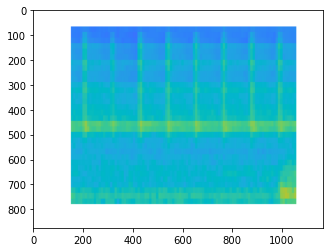

In [113]:
neu, spec = dataset[1]

print(spec.shape)
plt.imshow(spec.permute(1,2,0))
#neu shape is [repetition (2) x neurons (2048) x 15 (frames)]

(2, 2080, 3390)


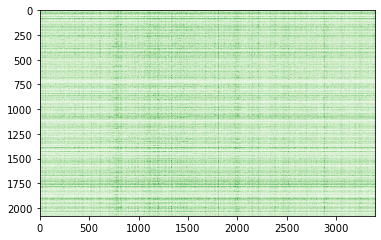

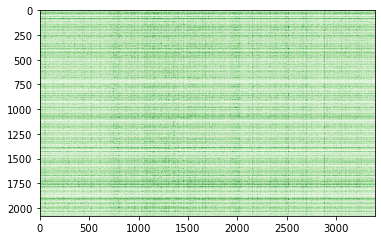

In [112]:
#visualize spikemaps

rufus_activation = np.zeros((2, 2080, 3390))
print(rufus_activation.shape)
for i, (neu, spec) in enumerate(dataloader) :
    rufus_activation[:, :, i*15 : i*15 + 15] = neu  


for k in range(2) :
    img = rufus_activation[k, :, :]
#print(img.shape)
    img = 255.0 * ((img - np.min(img)) / (np.max(img) - np.min(img)))
    plt.imshow(img, cmap='Greens', interpolation='nearest')
    plt.show()
